# Import libraries

In [1]:
import pandas as pd
from imgix import UrlBuilder
from google.cloud import vision
from google.oauth2 import service_account
import os
import lzma
import json
from sklearn.decomposition import LatentDirichletAllocation
from gensim import corpora, models
from gensim.matutils import Sparse2Corpus
from gensim.models import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models.ldamodel import LdaModel
from sklearn.metrics.pairwise import cosine_similarity

# Import Google Cloud credentials

In [2]:
# Path to your service account key file
key_path = "/Users/qianlou/Documents/GitHub/Social-Media-Analysis/forward-cacao-420716-6d4b68655e6d.json"

# Set up Google Vision client
credentials = service_account.Credentials.from_service_account_file(key_path)
# Initialize the Vision API Client
client = vision.ImageAnnotatorClient(credentials=credentials)

def detect_labels(image_path):
    """Detect labels in the image at the given path using Google Vision API."""
    with open(image_path, 'rb') as image_file:
        content = image_file.read()
    image = vision.Image(content=content)
    response = client.label_detection(image=image)
    return [label.description for label in response.label_annotations]

def find_key(data, target_key):
    """Recursively search for a key in JSON data."""
    if isinstance(data, dict):
        for key, value in data.items():
            if key == target_key:
                return value
            result = find_key(value, target_key)
            if result:
                return result
    elif isinstance(data, list):
        for item in data:
            result = find_key(item, target_key)
            if result:
                return result

# Import Data

URL Link: https://www.kaggle.com/datasets/thecoderenroute/instagram-posts-dataset?resource=download

In [44]:
data_folder_path = '/Users/qianlou/Documents/GitHub/Social-Media-Analysis/Data'

data = []  # List to hold all data extracted and processed

# Walk through the directory structure
for root, dirs, files in os.walk(data_folder_path):
    folder_name = os.path.basename(root)
    parts = folder_name.rsplit('_', 4)  # Split from the right to capture the last four elements distinctly
    
    if len(parts) < 5:
        continue  # Skip folders that do not have the expected number of parts

    profile_name = parts[0]  # Everything before the last four parts is the profile name
    follower_count, post_id, likes, comments = parts[1:]  # Unpack the last four parts in order
    
    all_labels = []
    json_data = {}

    for file in files:
        file_path = os.path.join(root, file)
        if file.endswith('.json.xz'):
            with lzma.open(file_path, 'rt') as json_file:
                json_data = json.load(json_file)
        elif file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_labels = detect_labels(file_path)
            all_labels.extend(image_labels)

    engagement_score = find_key(json_data, 'edge_media_to_comment')
    engagement_count = engagement_score.get('count') if engagement_score and isinstance(engagement_score, dict) and 'count' in engagement_score else None

    if all_labels:
        data.append({
            'profile_name': profile_name,
            'follower_count': follower_count,
            'post_id': post_id,
            'likes': likes,
            'comments': comments,
            'labels': ' '.join(all_labels),
            'engagement_score': engagement_count
        })

# Convert the list of data into a DataFrame
df = pd.DataFrame(data)

In [64]:
df.to_csv('data.csv', index=False)

# Read Again

In [3]:
df = pd.read_csv('data.csv')

In [4]:
df.head(5)

,profile_name,follower_count,post_id,likes,comments,labels,engagement_score
0,zomato,809822,3048876535670217534,22392,177,Food Ingredient Recipe Natural foods Cuisine D...,177
1,zomato,809822,3030021979666495337,17536,256,Rectangle Font Magenta Screenshot Parallel Num...,256
2,zomato,809822,3017722431480959941,6778,134,Font Screenshot Terrestrial plant Rectangle Nu...,134
3,zomato,809822,3058297827754329035,346067,1603,Bird Organism Beak Adaptation Terrestrial anim...,1603
4,zomato,809822,3053234851745688757,30434,142,Smile Product Happy Kitchen appliance Tablewar...,142


# Topic Modeling

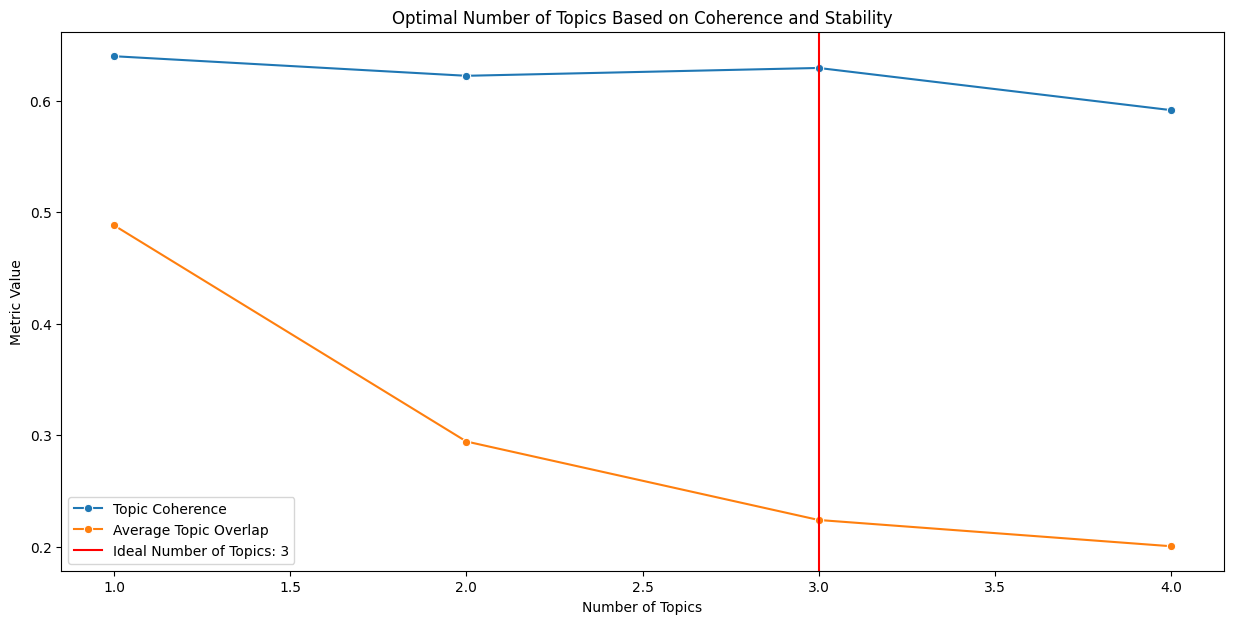

In [8]:
# Prepare data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english', tokenizer=lambda text: text.split())
data_vectorized = vectorizer.fit_transform(df['labels'])

# Compute LDA Models
LDA_models = {n_topics: LatentDirichletAllocation(n_components=n_topics, random_state=42).fit(data_vectorized)
              for n_topics in range(1, 6)}

# Prepare for coherence calculations
texts = [text.split() for text in df['labels']]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Calculate Coherence and handle possible errors
coherences = {}
for n_topics, model in LDA_models.items():
    topics = []
    for topic_idx, topic_dist in enumerate(model.components_):
        topic_terms = topic_dist.argsort()[-25:][::-1]
        topic_words = [dictionary[id] for id in topic_terms if id < len(dictionary)]
        topics.append(topic_words)
    if topics:
        coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence = coherence_model.get_coherence()
        coherences[n_topics] = coherence

# Calculate Jaccard similarity for topic stability
def jaccard_similarity(topic_1, topic_2):
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
    return float(len(intersection)) / float(len(union))

LDA_stability = {}
num_keywords = 25
for i in range(1, 5):  
    jaccard_sims = []
    current_topics = [set(top.argsort()[-num_keywords:]) for top in LDA_models[i].components_]
    next_topics = [set(top.argsort()[-num_keywords:]) for top in LDA_models[i + 1].components_]
    for current_topic in current_topics:
        sims = [jaccard_similarity(current_topic, next_topic) for next_topic in next_topics]
        jaccard_sims.append(sims)
    LDA_stability[i] = np.mean(jaccard_sims)

# Combine coherence and stability to determine the ideal number of topics
coh_sta_diffs = [coherences[i] - LDA_stability[i] for i in range(1, 5)]
ideal_topic_num_index = np.argmax(coh_sta_diffs)
ideal_topic_num = ideal_topic_num_index + 1  # Adjusting for zero index

# Plot results
plt.figure(figsize=(15, 7))
sns.lineplot(x=list(range(1, 5)), y=[coherences[i] for i in range(1, 5)], label='Topic Coherence', marker='o')
sns.lineplot(x=list(range(1, 5)), y=[LDA_stability[i] for i in range(1, 5)], label='Average Topic Overlap', marker='o')
plt.axvline(x=ideal_topic_num, label=f'Ideal Number of Topics: {ideal_topic_num}', color='red')
plt.title('Optimal Number of Topics Based on Coherence and Stability')
plt.xlabel('Number of Topics')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

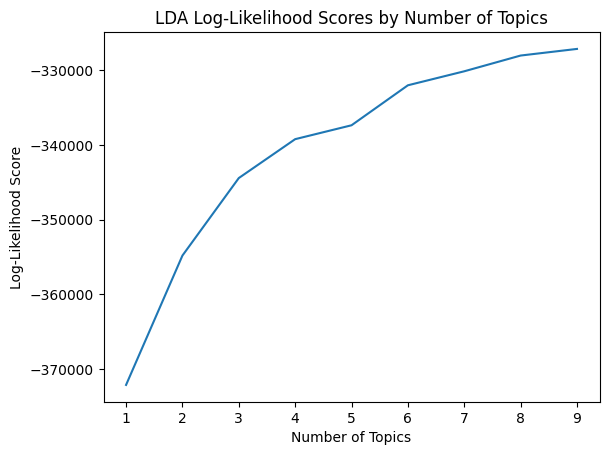

In [7]:
# Initialize a CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Fit and transform the labels data
data_vectorized = vectorizer.fit_transform(df['labels'])

# Function to compute LDA Model and its Coherence
def compute_lda(data_vectorized, n_topics, vectorizer):
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(data_vectorized)
    return lda

log_likelihoods = []
for n_topics in range(1, 10):  # Trying out different numbers of topics
    lda = compute_lda(data_vectorized, n_topics, vectorizer)
    log_likelihoods.append(lda.score(data_vectorized))

# Plotting the log likelihood scores
import matplotlib.pyplot as plt
plt.plot(range(1, 10), log_likelihoods)
plt.xlabel('Number of Topics')
plt.ylabel('Log-Likelihood Score')
plt.title('LDA Log-Likelihood Scores by Number of Topics')
plt.show()

In [ ]:
# Convert image labels to a matrix of token counts
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(data_df['labels'])

# Fit LDA model
lda = LatentDirichletAllocation(n_components=10, random_state=0)  # Adjust n_components as needed
topics = lda.fit_transform(X)

# Display top 25 words for each topic
features = vectorizer.get_feature_names_out()
top_words = lambda t: [features[i] for i in np.argsort(t)[:-26:-1]]
topic_words = ([top_words(t) for t in lda.components_])
print([' '.join(t) for t in topic_words])


# Engagement Analysis

In [ ]:
# Add topic distributions as features to the DataFrame
topic_columns = [f'topic_{i}' for i in range(lda.components_.shape[0])]
for index, topic_dist in enumerate(topics):
    data_df.loc[index, topic_columns] = topic_dist

# Sort data based on engagement and find quartiles
data_df.sort_values('comments', ascending=False, inplace=True)
quartile_size = len(data_df) // 4
top_quartile = data_df.head(quartile_size)
bottom_quartile = data_df.tail(quartile_size)

# Compare average topic weights between the top and bottom quartiles
average_top = top_quartile[topic_columns].mean()
average_bottom = bottom_quartile[topic_columns].mean()
comparison_df = pd.DataFrame({'Top Quartile': average_top, 'Bottom Quartile': average_bottom})
print(comparison_df)
